# Introduction to the xgbsurv package

This notebook introduces `xgbsurv` using a specific dataset. It structured by the following steps:

- Load data
- Load model
- Fit model
- Predict and evaluate model

The syntax conveniently follows that of sklearn.

In [10]:
from xgbsurv.datasets import load_metabric, load_rgbsg, load_support, load_flchain
from xgbsurv import XGBSurv
from xgbsurv.models.utils import sort_X_y, transform_back
from xgbsurv.evaluation import cindex_censored, ibs
#from xgbsurv.models import aft_baseline_hazard_estimator
from pycox.evaluation import EvalSurv
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [11]:
data = load_support(path="/Users/JUSC/Documents/xgbsurv/xgbsurv/datasets/data/", as_frame=False)
# stratify by event indicated by sign
target_sign = np.sign(data.target)
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, stratify=target_sign)
# sort data
X_train, y_train = sort_X_y(X_train, y_train)
X_test, y_test = sort_X_y(X_test, y_test)

In [12]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

## Load Model

In [13]:
early_stopping_rounds = 10
model = XGBSurv(n_estimators=500, objective="aft_objective",
                                             eval_metric="aft_loss",
                                             learning_rate=0.6,
                                             random_state=42, 
                                             disable_default_eval_metric=True,
                                             base_score=0.0,
                                             early_stopping_rounds=early_stopping_rounds,
                                             verbosity=3)

In [14]:
model.get_params

<bound method XGBModel.get_params of XGBSurv(base_score=0.0, booster=None, callbacks=None, colsample_bylevel=None,
        colsample_bynode=None, colsample_bytree=None,
        disable_default_eval_metric=True, early_stopping_rounds=10,
        enable_categorical=False,
        eval_metric=CPUDispatcher(<function aft_likelihood at 0x176b09300>),
        feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
        importance_type=None, interaction_constraints=None, learning_rate=0.6,
        max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
        max_delta_step=None, max_depth=None, max_leaves=None,
        min_child_weight=None, missing=nan, monotone_constraints=None,
        n_estimators=500, n_jobs=None, num_parallel_tree=None,
        objective=CPUDispatcher(<function aft_objective at 0x2b38fd9e0>), ...)>

The options of loss and objective functions can be obtained like below:

In [15]:
print(model.get_loss_functions().keys())
print(model.get_objective_functions().keys())

dict_keys(['breslow_loss', 'efron_loss', 'cind_loss', 'deephit_loss', 'aft_loss', 'ah_loss', 'eh_loss'])
dict_keys(['breslow_objective', 'efron_objective', 'cind_objective', 'deephit_objective', 'aft_objective', 'ah_objective', 'eh_objective'])


## Fit Model

In [16]:
eval_set = [(X_train, y_train)]

In [19]:
np.isnan(X_train).any()

False

In [18]:
validation_size = 0.2
model.fit(X_train, y_train,eval_test_size=validation_size )#eval_set=eval_set

[23:05:44] DEBUG: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/gbm/gbtree.cc:157: Using tree method: 2
[23:05:44] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[0]	validation_0-aft_likelihood:3.93181	validation_1-aft_likelihood:3.94378
[23:05:46] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[1]	validation_0-aft_likelihood:3.93180	validation_1-aft_likelihood:3.94378
[23:05:48] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[2]	validation_0-aft_likelihood:3.93180	validation

XGBSurv(base_score=0.0, booster=None, callbacks=None, colsample_bylevel=None,
        colsample_bynode=None, colsample_bytree=None,
        disable_default_eval_metric=True, early_stopping_rounds=10,
        enable_categorical=False,
        eval_metric=CPUDispatcher(<function aft_likelihood at 0x176b09300>),
        feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
        importance_type=None, interaction_constraints=None, learning_rate=0.6,
        max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
        max_delta_step=None, max_depth=None, max_leaves=None,
        min_child_weight=None, missing=nan, monotone_constraints=None,
        n_estimators=500, n_jobs=None, num_parallel_tree=None,
        objective=CPUDispatcher(<function aft_objective at 0x2b38fd9e0>), ...)

The model can be saved like below. Note that objective and eval_metric are not saved.

In [ ]:
model.save_model("introduction_model_aft.json")

## Predict

In [20]:
preds_train = model.predict(X_train)#, output_margin=True
preds_test = model.predict(X_test)#, output_margin=True
#time_train, event_train = transform_back(y_train)
#rlp = np.log(time_train * np.exp(preds_train))
#from xgbsurv.evaluation import cindex_censored, ibs
#cindex_censored(y_train, rlp)

In [21]:
df_cum_hazards = model.predict_cumulative_hazard_function(X_train, X_test, y_train, y_test)
df_survival_function = np.exp(-df_cum_hazards)
durations_test, events_test = transform_back(y_test)
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev = EvalSurv(df_survival_function, durations_test, events_test, censor_surv='km')
print('Concordance Index',ev.concordance_td('antolini'))
print('Brier Index',ev.integrated_brier_score(time_grid))

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Concordance Index 0.026960816453455373
Brier Index 0.21523141498576517


In [22]:
cindex_censored(y_train, preds_train)

0.5084467980967713

In [ ]:
cindex_censored(y_test, preds_test)

0.6327525820636057

### Predict Cumulative Hazard

In [ ]:
df_cum_hazards = model.predict_cumulative_hazard_function(X_train, X_test, y_train, y_test)
df_cum_hazards #.T

,0,1,2,3,4,5,6,7,8,9,...,466,467,468,469,470,471,472,473,474,475
0.766667,0.000701,0.000701,0.000701,0.000701,0.000701,0.000701,0.000701,0.000701,0.000701,0.000701,...,0.000701,0.000701,0.000701,0.000701,0.000701,0.000701,0.000701,0.000701,0.000701,0.000701
1.233333,0.000706,0.000713,0.000713,0.000716,0.000716,0.000710,0.000708,0.000710,0.000716,0.000710,...,0.000708,0.000705,0.000713,0.000708,0.000710,0.000710,0.000710,0.000708,0.000706,0.000710
2.533333,0.001287,0.001426,0.001426,0.001482,0.001510,0.001343,0.001315,0.001370,0.001510,0.001370,...,0.001343,0.001233,0.001454,0.001287,0.001370,0.001370,0.001343,0.001343,0.001260,0.001370
3.500000,0.002020,0.002204,0.002231,0.002284,0.002311,0.002125,0.002072,0.002151,0.002338,0.002151,...,0.002072,0.001967,0.002257,0.002046,0.002151,0.002151,0.002125,0.002098,0.001993,0.002125
4.433333,0.002769,0.003022,0.003055,0.003122,0.003190,0.002893,0.002800,0.002957,0.003224,0.002957,...,0.002830,0.002649,0.003088,0.002769,0.002925,0.002925,0.002893,0.002862,0.002738,0.002925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285.700012,1.267329,1.360975,1.369698,1.396196,1.412256,1.312885,1.285999,1.331544,1.422333,1.331544,...,1.296275,1.229470,1.383206,1.272810,1.325040,1.327436,1.312885,1.299871,1.254138,1.323499
297.233337,1.323157,1.420625,1.429504,1.456977,1.473686,1.370553,1.342497,1.389872,1.484082,1.389872,...,1.353277,1.283773,1.443499,1.328977,1.383035,1.385599,1.370553,1.357040,1.309460,1.381496
298.033325,1.327094,1.424723,1.433601,1.461240,1.477948,1.374486,1.346433,1.393974,1.488342,1.393974,...,1.357212,1.287541,1.447594,1.332742,1.387137,1.389701,1.374486,1.360975,1.313227,1.385599
301.233337,1.342497,1.441110,1.450324,1.478118,1.494985,1.390385,1.362172,1.410036,1.505542,1.410036,...,1.372947,1.302611,1.464310,1.348315,1.403202,1.405765,1.390385,1.376880,1.328634,1.401664


In [ ]:
np.savetxt('debug_files/X_train.csv', X_train, delimiter=',')
np.savetxt('debug_files/X_test.csv', X_test, delimiter=',')
#np.savetxt('/debug_files/y_train.csv', y_train, delimiter=',')
np.savetxt('debug_files/y_test.csv', y_test, delimiter=',')

time_test, event_test = transform_back(y_test)
np.savetxt('debug_files/time.csv', np.unique(time_test), delimiter=',')
time_train, event_train = transform_back(y_train)
np.savetxt('debug_files/time_train.csv', time_train, delimiter=',')
np.savetxt('debug_files/event_train.csv', event_train, delimiter=',')
np.savetxt('debug_files/predictor_train.csv', preds_train, delimiter=',')
np.savetxt('debug_files/predictor_test.csv', preds_test, delimiter=',')

In [ ]:
df_survival_function = np.exp(-df_cum_hazards)
#df_survival_function = df_survival_function.T.sort_index(axis=1)

In [ ]:
df_survival_function.to_csv('aft_sample_surv.csv')

Text(0.5, 1.0, 'Survival Curve Test Set')

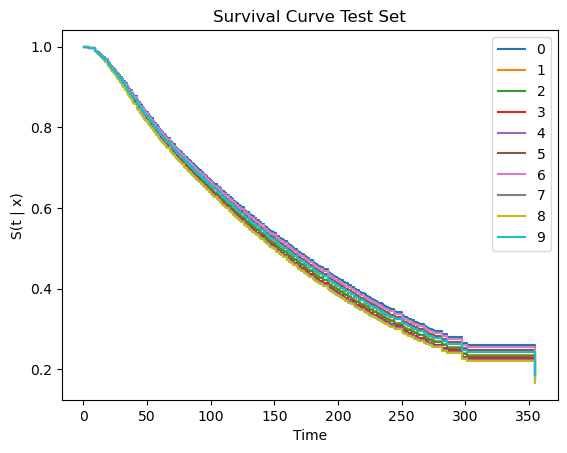

In [ ]:
#df_survival_function = np.exp(-df_cum_hazards)
#df_survival_function = df_survival_function.astype(np.float32)
df_survival_function.iloc[:, :10].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')
plt.title("Survival Curve Test Set")

In [ ]:
durations_test, events_test = transform_back(y_test)
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev = EvalSurv(df_survival_function, durations_test, events_test, censor_surv='km')
print('Concordance Index',ev.concordance_td('antolini'))
print('Brier Index',ev.integrated_brier_score(time_grid))

Concordance Index 0.6225841088045813
Brier Index 0.17457326196574519


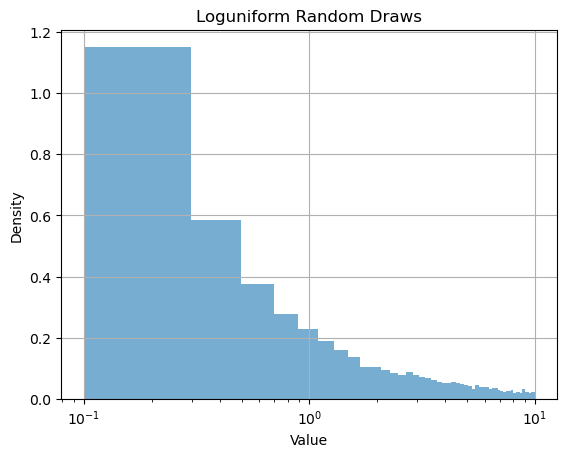

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Number of draws
num_draws = 10000

# Specify the range for the loguniform distribution
low = 0.1
high = 10.0

# Generate loguniform random draws
loguniform_draws = np.exp(np.random.uniform(np.log(low), np.log(high), num_draws))

# Plot the histogram of the draws
plt.hist(loguniform_draws, bins=50, density=True, alpha=0.6)
plt.xscale('log')  # To get a log-scaled x-axis
plt.title('Loguniform Random Draws')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()


In [ ]:
from xgbsurv.datasets import (load_metabric, load_flchain, load_rgbsg, load_support, load_tcga)
from xgbsurv import XGBSurv
from xgbsurv.evaluation import cindex_censored, ibs
from xgbsurv.models.utils import sort_X_y
import os
import numpy as np
import pandas as pd
from scipy.stats import uniform as scuniform
from scipy.stats import randint as scrandint
from scipy.stats import loguniform as scloguniform 
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.decomposition import PCA
# import models
from xgbsurv.models.eh_aft_final import aft_likelihood, get_cumulative_hazard_function_aft
from pycox.evaluation import EvalSurv
from xgbsurv.models.utils import sort_X_y_pandas, transform_back, transform
from xgbsurv.preprocessing.dataset_preprocessing import discretizer_df
from sklearn.utils.fixes import loguniform
np.random.seed(42)

In [ ]:
param_grid = {
#'estimator__reg_alpha': scloguniform(1e-10,1),#[1e-10,1], # from hyp augmentation, L1 regularization
'estimator__reg_lambda': scloguniform(1e-10,1), #[1e-10,1], #alias l2_regularization, lambda in augmentation
'estimator__learning_rate': scloguniform(0.01,1.0), #[0.001,1], # assumed alias eta from augmentation,
'estimator__n_estimators':  scrandint(1,100),#00), # corresponds to num_rounds
#'estimator__gamma': [0],#loguniform(0.001,1-0.5),#[0.1,1], # minimum loss reduction required to make a further partition on a leaf node of the tree.
'estimator__colsample_bylevel': scuniform(0.1, 1-0.1), #[0.1,1], # from hyp augmentation
'estimator__colsample_bynode': scuniform(0.1, 1-0.1), #[0.1,1], # from hyp augmentation, uniform(0.1,1),
'estimator__colsample_bytree': scuniform(0.5, 1-0.5),#[0.5,1], # from hyp augmentation, seems to exceed the bound, uniform(0.5,1)
'estimator__max_depth': scrandint(1,20),#[1,20], # from hyp augmentation
'estimator__max_delta_step': scrandint(0,10),#[0,10], # from hyp augmentation
'estimator__min_child_weight' : scloguniform(0.1,20-0.1),#[0.1,20], # from hyp augmentation
'estimator__subsample': scuniform(0.01,1-0.01),#[0.01,1], # from hyp augmentation
}
n_outer_splits = 5
n_inner_splits = 5
rand_state = 42
n_iter = 1 #50 #0
early_stopping_rounds=10
base_score = 0.0
validation_size = 0.2

In [ ]:
#scoring_function = make_scorer(aft_likelihood, greater_is_better=False) #changed here
def custom_scoring_function(y_true, y_pred):

        if not isinstance(y_true, np.ndarray):
            y_true = y_true.values
        if not isinstance(y_pred, np.ndarray):
            y_pred = y_pred.values
        # change order of this later
        score = aft_likelihood(y_true, y_pred)
        return score

scoring_function = make_scorer(custom_scoring_function, greater_is_better=False)

In [ ]:
class CustomSplit(StratifiedKFold):
    def __init__(self, n_splits=5, shuffle=True, random_state=None):
        super().__init__(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    def split(self, X, y, groups=None):
        try:
            if y.shape[1]>1:
                y = y[:,0]
        except:
            pass
        bins = np.sign(y)
        return super().split(X, bins, groups=groups)

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

outer_custom_cv = CustomSplit(n_splits=n_outer_splits, shuffle=True, random_state=rand_state)
inner_custom_cv = CustomSplit(n_splits=n_outer_splits, shuffle=True, random_state=rand_state)

In [ ]:
ct = make_column_transformer(
        (StandardScaler(), make_column_selector(dtype_include=['float32'])),
        #(OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'), make_column_selector(dtype_include=['category', 'object'])),
        remainder='passthrough')

estimator = XGBSurv(
    objective='aft_objective',
    eval_metric='aft_loss',
    random_state=rand_state, 
    disable_default_eval_metric=True,
    early_stopping_rounds=early_stopping_rounds, 
    base_score=base_score,
                    )
pipe = Pipeline([('scaler',ct),
                ('estimator', estimator)])
    
rs = RandomizedSearchCV(pipe, param_grid, scoring = scoring_function, n_jobs=-1, 
                             cv=inner_custom_cv, n_iter=1, refit=True, 
                             random_state=rand_state, verbose=10,
                             error_score = 'raise')
data = load_metabric(path="/Users/JUSC/Documents/xgbsurv/xgbsurv/datasets/data/", as_frame=True)
filename = data.filename
X  = data.data #.astype(np.float32)
y = data.target #.values #.to_numpy()

for i, (train_index, test_index) in enumerate(outer_custom_cv.split(X, y)):
        # Split data into training and testing sets for outer fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train, y_train = sort_X_y_pandas(X_train, y_train)
        X_test, y_test = sort_X_y_pandas(X_test, y_test)
        rs.fit(X_train, y_train, estimator__eval_test_size=validation_size)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 5/5; 1/1] START estimator__colsample_bylevel=0.4370861069626263, estimator__colsample_bynode=0.9556428757689246, estimator__colsample_bytree=0.8659969709057025, estimator__learning_rate=0.15751320499779722, estimator__max_delta_step=6, estimator__max_depth=19, estimator__min_child_weight=0.16975698090861446, estimator__n_estimators=75, estimator__reg_lambda=0.045894586123264684, estimator__subsample=0.6051038616257767
[CV 1/5; 1/1] START estimator__colsample_bylevel=0.4370861069626263, estimator__colsample_bynode=0.9556428757689246, estimator__colsample_bytree=0.8659969709057025, estimator__learning_rate=0.15751320499779722, estimator__max_delta_step=6, estimator__max_depth=19, estimator__min_child_weight=0.16975698090861446, estimator__n_estimators=75, estimator__reg_lambda=0.045894586123264684, estimator__subsample=0.6051038616257767
[CV 2/5; 1/1] START estimator__colsample_bylevel=0.4370861069626263, estimator__colsample

KeyboardInterrupt: 

In [ ]:
best_preds_train = rs.best_estimator_.predict(X_train)
best_preds_test = rs.best_estimator_.predict(X_test)
print('best_preds_train',best_preds_train)
print('best_preds_test',best_preds_test)
print(best_preds_train.shape)
print(best_preds_test.shape)

best_preds_train [ 0.00106906 -0.00071109  0.00305569 ... -0.00246784 -0.00213255
 -0.00110671]
best_preds_test [ 9.7548368e-04  3.2947727e-03 -1.8001143e-03  8.1274519e-04
 -5.4536248e-04  5.9510274e-03 -3.6984132e-04  2.5419737e-03
  2.0386777e-03  1.2170672e-03  3.8539888e-03  3.5654526e-04
  2.4914456e-04  1.8987983e-03  1.9936843e-03  3.7411801e-03
  1.6245929e-03  1.4242115e-03  6.7414390e-04 -2.6396511e-03
 -1.8794109e-03  2.0024546e-03 -2.6801734e-03  4.2802040e-04
  2.2871066e-03  1.8001992e-03  6.4201729e-04  2.2066098e-03
  1.1907335e-03  1.8285288e-03  1.2581226e-03 -1.8015952e-03
  3.4712898e-03 -2.0756156e-03  9.6165272e-04  1.2247963e-03
  2.5934624e-03  6.3202390e-04  1.4432246e-03  2.4136796e-03
  1.4290554e-03  2.1245051e-03 -2.5766972e-03 -3.9548869e-04
 -3.6266743e-04  3.3058606e-03  2.6206521e-03  8.8916818e-04
  3.9494568e-03  3.0635120e-04  1.1268565e-03  2.4204843e-03
 -5.8178394e-04  2.7955130e-03 -1.4995744e-03  2.7625563e-03
  3.1597984e-03 -8.8305993e-04  6.

In [ ]:
from sklearn._config import get_config, set_config
set_config(print_changed_only=False)
rs.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('standardscaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd3884076a0>)],
                                   verbose=False,
                                   verbose_feature_names_out=Tr...
                         learning_rate=0.15751320499779722, max_bin=None,
                         max_cat_threshold=None, max_cat_to_onehot=None,
                         max_delta_step=6, max_depth=19, max_leaves=None,
                         min_child_weight=0.16975698090861446, missing=nan,
                         monotone_constraints=None, n_estimators=75,
                         n_jobs=None, num_parallel_tree=None,
                         objective=CPUDispatcher(<function aft_objective at 0x7fd3614c1bd0>), ...))],
         verbose=False)

In [ ]:
cum_hazard_train = get_cumulative_hazard_function_aft(
        X_train.values, X_test.values, y_train.values, y_test.values,
        best_preds_train.reshape(-1), best_preds_train.reshape(-1)
        )

df_survival_train = np.exp(-cum_hazard_train)
durations_train, events_train = transform_back(y_train.values)
time_grid_train = np.linspace(durations_train.min(), durations_train.max(), 100)
ev = EvalSurv(df_survival_train, durations_train, events_train, censor_surv='km')
print('Concordance Index',ev.concordance_td('antolini'))
print('Integrated Brier Score:',ev.integrated_brier_score(time_grid_train))

Concordance Index 0.687149870414673
Integrated Brier Score: 0.1786393422508998


In [ ]:

durations_test, events_test = transform_back(y_test)
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev = EvalSurv(df_survival_function, durations_test, events_test, censor_surv='km')
print('Concordance Index',ev.concordance_td('antolini'))

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at /Users/JUSC/miniconda3/envs/xgbsurv/lib/python3.10/site-packages/xgbsurv/models/utils.py (56)[0m
[1m
File "../../../miniconda3/envs/xgbsurv/lib/python3.10/site-packages/xgbsurv/models/utils.py", line 56:[0m
[1mdef transform_back(y: npt.NDArray[float]) -> tuple[npt.NDArray[float], npt.NDArray[int]]:
    <source elided>
    """
[1m    time = np.abs(y)
[0m    [1m^[0m[0m 

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class 'pandas.core.series.Series'>[0m


In [ ]:
from typing import Tuple, Callable
from xgbsurv.models.utils import transform, transform_back
import numpy as np
from numba import jit
import pandas as pd
from scipy.integrate import quad, cumtrapz, quadrature
from functools import partial
from numba import cfunc

# verify if below are really required?
from scipy.stats import norm
from sklearn.utils.extmath import safe_sparse_dot
from typeguard import typechecked

from math import exp, sqrt, pi, erf, pow, log

PDF_PREFACTOR: float = 0.3989424488876037
SQRT_TWO: float = 1.4142135623730951
SQRT_EPS: float = 1.4901161193847656e-08
EPS: float = 2.220446049250313e-16
CDF_ZERO: float = 0.5

@jit(nopython=True, cache=True, fastmath=True)
def gaussian_integrated_kernel(x):
    return 0.5 * (1 + erf(x / SQRT_TWO))


@jit(nopython=True, cache=True, fastmath=True)
def gaussian_kernel(x):
    return PDF_PREFACTOR * exp(-0.5 * (x**2))


@jit(nopython=True, cache=True, fastmath=True)
def kernel(a, b, bandwidth):
    kernel_matrix: np.array = np.empty(shape=(a.shape[0], b.shape[0]))
    for ix in range(a.shape[0]):
        for qx in range(b.shape[0]):
            kernel_matrix[ix, qx] = gaussian_kernel(
                (a[ix] - b[qx]) / bandwidth
            )
    return kernel_matrix


@jit(nopython=True, cache=True, fastmath=True)
def integrated_kernel(a, b, bandwidth):
    integrated_kernel_matrix: np.array = np.empty(
        shape=(a.shape[0], b.shape[0])
    )
    for ix in range(a.shape[0]):
        for qx in range(b.shape[0]):
            integrated_kernel_matrix[ix, qx] = gaussian_integrated_kernel(
                (a[ix] - b[qx]) / bandwidth
            )
    return integrated_kernel_matrix

def aft_baseline_hazard_estimator(
    time, # unique test time(?), time to integrate over
    time_train,
    event_train,
    predictor_train,
):
    n_samples: int = time_train.shape[0]
    bandwidth = 1.30 * pow(n_samples, -0.2)
    inverse_bandwidth: float = 1 / bandwidth
    inverse_sample_size: float = 1 / n_samples
    log_time: float = log(time + EPS)
    inverse_bandwidth_sample_size_time: float = (
        inverse_sample_size * (1 / (time + EPS)) * inverse_bandwidth
    )

    R_lp: np.array = np.log(time_train * np.exp(predictor_train))
    difference_lp_log_time: np.array = (R_lp - log_time) / bandwidth
    numerator: float = 0.0
    denominator: float = 0.0
    for _ in range(n_samples):
        difference_div: float = difference_lp_log_time[_]
        denominator += gaussian_integrated_kernel(difference_div)
        if event_train[_]:
            numerator += gaussian_kernel(difference_div)
    numerator = inverse_bandwidth_sample_size_time * numerator
    denominator = inverse_sample_size * denominator
    return numerator / denominator

# latest version
def aft_get_cumulative_hazard_function(
    time,
    time_train,
    event_train,
    predictor_train,
    predictor_test,
    granularity=10.0,
):
    theta: np.array = np.exp(predictor_test)
    print('theta shape', theta.shape)
    n_samples: int = predictor_test.shape[0]

    zero_flag: bool = False
    if 0 not in time:
        zero_flag = True
        time = np.concatenate([np.array([0]), time])
        cumulative_hazard: np.array = np.empty((n_samples, time.shape[0]))
    else:
        cumulative_hazard: np.array = np.empty((n_samples, time.shape[0]))

    def hazard_function_integrate(s):
        return aft_baseline_hazard_estimator(
            time=s,
            time_train=time_train,
            event_train=event_train,
            predictor_train=predictor_train,    
        )

    print(np.min(time))
    integration_times = np.arange(
        start=np.round(np.min(theta) * np.min(time)),
        stop=np.round(np.max(theta) * np.max(time)),
        step=granularity,
    )
    print('after integration times 1')
    integration_times = np.concatenate([[0], integration_times])
    print('after integration times 2')
    integration_values = np.zeros(integration_times.shape[0])
    for _ in range(1, integration_values.shape[0]):
        integration_values[_] = (
            integration_values[_ - 1]
            + quadrature(
                func=hazard_function_integrate,
                a=integration_times[_ - 1],
                b=integration_times[_],
                vec_func=False,
            )[0]
        )

    for _ in range(n_samples):
        cumulative_hazard[_] = integration_values[
            np.digitize(x=time * theta[_], bins=integration_times, right=False)
            - 1
        ]
    if zero_flag:
        cumulative_hazard = cumulative_hazard[:, 1:]
        time = time[1:]
    return pd.DataFrame(cumulative_hazard, columns=time)

In [ ]:
time_test, event_test = transform_back(y_test)
preds_train = model.predict(X_train)#, output_margin=True
preds_test = model.predict(X_test)
d = aft_get_cumulative_hazard_function(
    np.unique(time_test),
    time_train,
    event_train,
    preds_train,
    preds_test,
    granularity=20.0,
)
d.shape

NameError: name 'aft_get_cumulative_hazard_function' is not defined

In [ ]:
df_survival_function = np.exp(-d)
df_survival_function = df_survival_function.astype(np.float32)
df_survival_function

,2.000000,2.500000,2.533333,6.266667,9.066667,9.433333,9.600000,9.833333,10.833333,10.866667,...,275.633331,275.733337,278.266663,287.933319,291.166656,296.866669,300.700012,318.200012,335.600006,351.000000
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.328328,0.328328,0.328328,0.295159,0.295159,0.295159,0.264995,0.264995,0.237682,0.213038
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.295159,0.295159,0.295159,0.295159,0.264995,0.264995,0.264995,0.237682,0.213038,0.190858
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.264995,0.264995,0.264995,0.264995,0.237682,0.237682,0.237682,0.213038,0.190858,0.170934
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.264995,0.264995,0.264995,0.237682,0.237682,0.237682,0.213038,0.213038,0.190858,0.170934
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.295159,0.295159,0.295159,0.295159,0.295159,0.264995,0.264995,0.237682,0.237682,0.213038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.295159,0.295159,0.295159,0.295159,0.264995,0.264995,0.264995,0.237682,0.213038,0.213038
472,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.295159,0.295159,0.295159,0.295159,0.295159,0.264995,0.264995,0.237682,0.237682,0.213038
473,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.295159,0.295159,0.295159,0.264995,0.264995,0.264995,0.264995,0.237682,0.213038,0.190858
474,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.295159,0.295159,0.295159,0.295159,0.295159,0.264995,0.264995,0.237682,0.237682,0.213038


In [ ]:
durations_test, events_test = transform_back(y_test)
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev = EvalSurv(df_survival_function.T.sort_index(), durations_test, events_test, censor_surv='km')
print('Concordance Index',ev.concordance_td('antolini'))

Concordance Index 0.08926693473553975


In [ ]:
print(np.unique(time_test).shape,
    time_train.shape,
    event_train.shape,
    preds_train.shape,
    preds_test.shape)
#(467,) (1427,) (1427,) (1427,) (476,)

(462,) (1427,) (1427,) (1427,) (476,)


In [ ]:
np.exp(-d)

,2.000000,2.500000,2.533333,6.266667,9.066667,9.433333,9.600000,9.833333,10.833333,10.866667,...,275.633331,275.733337,278.266663,287.933319,291.166656,296.866669,300.700012,318.200012,335.600006,351.000000
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.328328,0.328328,0.328328,0.295159,0.295159,0.295159,0.264995,0.264995,0.237682,0.213038
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.295159,0.295159,0.295159,0.295159,0.264995,0.264995,0.264995,0.237682,0.213038,0.190858
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.264995,0.264995,0.264995,0.264995,0.237682,0.237682,0.237682,0.213038,0.190858,0.170934
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.264995,0.264995,0.264995,0.237682,0.237682,0.237682,0.213038,0.213038,0.190858,0.170934
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.295159,0.295159,0.295159,0.295159,0.295159,0.264995,0.264995,0.237682,0.237682,0.213038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.295159,0.295159,0.295159,0.295159,0.264995,0.264995,0.264995,0.237682,0.213038,0.213038
472,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.295159,0.295159,0.295159,0.295159,0.295159,0.264995,0.264995,0.237682,0.237682,0.213038
473,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.295159,0.295159,0.295159,0.264995,0.264995,0.264995,0.264995,0.237682,0.213038,0.190858
474,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.295159,0.295159,0.295159,0.295159,0.295159,0.264995,0.264995,0.237682,0.237682,0.213038


## Predict Survival Function

In [ ]:
df_survival_function = model.predict_survival_function(X_train, X_test, y_train, y_test)
df_survival_function.tail(3)

,0,1,2,3,4,5,6,7,8,9,...,466,467,468,469,470,471,472,473,474,475
318.200012,0.241719,0.226924,0.203765,0.191910,0.236460,0.226924,0.206582,0.223351,0.236288,0.206318,...,0.236460,0.219993,0.217993,0.223718,0.235301,0.228127,0.235301,0.217317,0.234916,0.214751
335.600006,0.221201,0.206847,0.184586,0.173280,0.216089,0.206847,0.187317,0.203429,0.215931,0.187043,...,0.216089,0.200176,0.198278,0.203765,0.214986,0.208062,0.214986,0.197625,0.214594,0.195140
351.000000,0.204438,0.190542,0.169125,0.158284,0.199481,0.190542,0.171726,0.187249,0.199334,0.171473,...,0.199481,0.184112,0.182262,0.187593,0.198387,0.191699,0.198387,0.181627,0.198060,0.179273


### Visualize Predictions

Text(0.5, 1.0, 'Survival Curve Test Set')

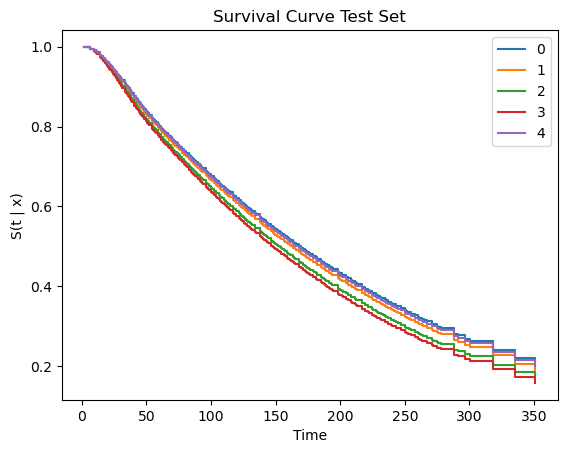

In [ ]:
df_survival_function.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')
plt.title("Survival Curve Test Set")

## Evaluate

In [ ]:
durations_test, events_test = transform_back(y_test)
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev = EvalSurv(df_survival_function, durations_test, events_test, censor_surv='km')
print('Concordance Index',ev.concordance_td('antolini'))

Concordance Index 0.6070646458397773


In [ ]:
print('Integrated Brier Score:',ev.integrated_brier_score(time_grid))

Integrated Brier Score: 0.18551198595050641
